In [52]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor

from import_merged import NEW_FEATURES
from sklearn.preprocessing import PowerTransformer


In [53]:
#first inspection
NEW_FEATURES.head()

,Anlieferungsdatum,Material,Gewicht in Tonnen,Day,Workday,Total Pedestrians,Location,Temperature mean,Temperature max,Temperature min,Precipitation in mm,Snow amount in cm,Total Costs
0,2021-09-20,Inertstoffe,3.14,1,1,2687.0,St. Gallen,10.7,12.8,9.0,1.1,0.0,0.0
1,2021-09-20,stark verschmutzte Abfälle,21.04,1,1,2687.0,St. Gallen,10.7,12.8,9.0,1.1,0.0,0.0
2,2021-09-20,stark verschmutzte Abfälle,22.00,1,1,2687.0,St. Gallen,10.7,12.8,9.0,1.1,0.0,0.0
3,2021-09-20,stark verschmutzte Abfälle,8.12,1,1,2687.0,St. Gallen,10.7,12.8,9.0,1.1,0.0,0.0
4,2021-09-20,Inertstoffe,3.38,1,1,2687.0,St. Gallen,10.7,12.8,9.0,1.1,0.0,0.0


In [54]:
#for time-series random forest you need to lag features and target to preserve temporal order 
def create_lagged_features(df, target_column, lags):
    lagged_df = pd.DataFrame()
    for lag in range(1, lags + 1):
        for col in df.columns:
            lagged_df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    lagged_df[target_column] = df[target_column]  # Keep the target variable
    return lagged_df

# Generate lagged features
#afterwards test for optimal lags
lags = 3  # Use 3 lag steps
lagged_data = create_lagged_features(NEW_FEATURES, 'Gewicht in Tonnen', lags)

# Drop NaN values caused by lagging
lagged_data = lagged_data.dropna()

In [85]:
# Define features and target

# Defining the target 
target = 'Gewicht in Tonnen'

# Defining the features
features = ['Day', 'Workday', 'Total Pedestrians', 'Temperature mean', 'Temperature max', 'Temperature min', 'Precipitation in mm', 'Snow amount in cm', 'Total Costs']

X = NEW_FEATURES.groupby("Anlieferungsdatum")[features].sum()
# Sum the target for each day
y = NEW_FEATURES.groupby('Anlieferungsdatum')[target].sum()

# Apply Yeo-Johnson transformation to the target 
pt = PowerTransformer(method='yeo-johnson')
y_transformed = pt.fit_transform(y.values.reshape(-1, 1)).flatten()

# Apply Yeo-Johnson transformation to the features 
X_transformed = pt.fit_transform(X.values.reshape(-1, 1)).flatten()

X = X_transformed
y = y_transformed



In [86]:

# # Convert numpy arrays back to pandas DataFrames (so that yeo johnson works properly)
X = pd.DataFrame(X.reshape(-1, len(features)), columns=features)
y = pd.Series(y, name=target)

#define number of estimators 
B = 100
# Define the number of splits for rolling cross-validation
n_splits = min(10, len(X) // 2)  # make sure they are posssible
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store MSE
mse_train_rf_list = []
mse_test_rf_list = []

#feasibility check
assert len(X) == len(y), f"Length mismatch: X has {len(X)} rows, y has {len(y)} rows."


# TimeSeriesSplit
for train_index, test_index in tscv.split(X):
    # Use the indices directly without extra filtering
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Create and train the random forest regressor
    rf_regressor = RandomForestRegressor(n_estimators=B, random_state=42, max_features='sqrt', max_depth=16, min_samples_split=2, min_samples_leaf=1)
    rf_regressor.fit(X_train, y_train)
    
    # Predictions
    y_train_pred_rf = rf_regressor.predict(X_train)
    y_test_pred_rf = rf_regressor.predict(X_test)
    
    # Evaluating the model
    mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
    mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
    
    mse_train_rf_list.append(mse_train_rf)
    mse_test_rf_list.append(mse_test_rf)

# average mean squared error for train and test sets
avg_mse_train_rf = np.mean(mse_train_rf_list)
avg_mse_test_rf = np.mean(mse_test_rf_list)

print(f'Average Mean Squared Error for the random forest (train): {avg_mse_train_rf}')
print(f'Average Mean Squared Error for the random forest (test): {avg_mse_test_rf}')


Average Mean Squared Error for the random forest (train): 0.007269675602304256
Average Mean Squared Error for the random forest (test): 0.09499229975655774


Base random forest is performing very well on train set but has a much higher MSE on the test set. Also, the graph below shows a good visual interpretation of this overfitting behavior. To combat this we are trying a couple of measures:
1) tuning the max depth parameter: optimal is 16. reduces difference between MSE train and test but doesnt "cure" our problem.
2) reducing max_features to sqrt (analogue to notebook) --> doesnt help much aswell
3) tuning the number of estimators (usually a higher value decreases variance, excessive trees can lead to overfitting.)
not true in this case
4) using cross validation --> disciplined way to find best parameters? -> grid search
5) tune min sample split and min samples leaf aswell
6) see if certain features dominate the prediction and remove multicollinear ones


In [83]:
from sklearn.model_selection import GridSearchCV


# # Convert numpy arrays back to pandas DataFrames (so that yeo johnson works properly)
X = pd.DataFrame(X.reshape(-1, len(features)), columns=features)
y = pd.Series(y, name=target)

#define number of estimators 
B = 200
# Define the number of splits for rolling cross-validation
n_splits = min(10, len(X) // 2)  # make sure they are posssible
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store MSE
mse_train_rf_list = []
mse_test_rf_list = []

#feasibility check
assert len(X) == len(y), f"Length mismatch: X has {len(X)} rows, y has {len(y)} rows."


# TimeSeriesSplit
for train_index, test_index in tscv.split(X):
    # Use the indices directly without extra filtering
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Create and train the random forest regressor
    rf_regressor = RandomForestRegressor(n_estimators=B, random_state=42, max_features='sqrt', max_depth=10)
    rf_regressor.fit(X_train, y_train)
    
    # Predictions
    y_train_pred_rf = rf_regressor.predict(X_train)
    y_test_pred_rf = rf_regressor.predict(X_test)
    
    # Evaluating the model
    mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
    mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
    
    mse_train_rf_list.append(mse_train_rf)
    mse_test_rf_list.append(mse_test_rf)

# average mean squared error for train and test sets
avg_mse_train_rf = np.mean(mse_train_rf_list)
avg_mse_test_rf = np.mean(mse_test_rf_list)

print(f'Average Mean Squared Error for the random forest (train): {avg_mse_train_rf}')
print(f'Average Mean Squared Error for the random forest (test): {avg_mse_test_rf}')

# Define the parameter grid including min_samples_split and min_samples_leaf
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 16, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the grid search with the updated parameter grid
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=tscv,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X, y)


# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print(f'Best parameters found: {best_params}')
print(f'Best score (MSE): {best_score}')

Average Mean Squared Error for the random forest (train): 0.010441456731698025
Average Mean Squared Error for the random forest (test): 0.09292452430250689
Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score (MSE): 0.09292452430250689


In [70]:
# Define the range of max depths to test
max_depths = range(1, 21)

# Initialize a dictionary to store the average MSE for each max depth
mse_test_rf_dict = {}

for max_depth in max_depths:
    # Initialize lists to store MSE for each fold
    mse_train_rf_list = []
    mse_test_rf_list = []

    # TimeSeriesSplit
    for train_index, test_index in tscv.split(X):
        # Use the indices directly without extra filtering
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create and train the random forest regressor with the current max depth
        rf_regressor = RandomForestRegressor(n_estimators=B, random_state=42, max_features='sqrt', max_depth=max_depth)
        rf_regressor.fit(X_train, y_train)

        # Predictions
        y_train_pred_rf = rf_regressor.predict(X_train)
        y_test_pred_rf = rf_regressor.predict(X_test)

        # Evaluating the model
        mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
        mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)

        mse_train_rf_list.append(mse_train_rf)
        mse_test_rf_list.append(mse_test_rf)

    # Calculate the average MSE for the current max depth
    avg_mse_test_rf = np.mean(mse_test_rf_list)
    mse_test_rf_dict[max_depth] = avg_mse_test_rf

# Find the max depth with the lowest average MSE for the test set
optimal_max_depth = min(mse_test_rf_dict, key=mse_test_rf_dict.get)
print(f'Optimal max depth: {optimal_max_depth}')
print(f'Lowest average MSE for the test set: {mse_test_rf_dict[optimal_max_depth]}')
# Find the max depth with the lowest difference between train and test MSE
mse_diff_dict = {depth: abs(np.mean(mse_train_rf_list) - mse) for depth, mse in mse_test_rf_dict.items()}
optimal_max_depth_diff = min(mse_diff_dict, key=mse_diff_dict.get)
print(f'Optimal max depth based on the lowest difference between train and test MSE: {optimal_max_depth_diff}')
print(f'Lowest difference between train and test MSE: {mse_diff_dict[optimal_max_depth_diff]}')

# Print the MSE for both test and train
print(f'Average Mean Squared Error for the random forest (train): {avg_mse_train_rf}')
print(f'Average Mean Squared Error for the random forest (test): {avg_mse_test_rf}')



Optimal max depth: 16
Lowest average MSE for the test set: 0.08803434491772925
Optimal max depth based on the lowest difference between train and test MSE: 16
Lowest difference between train and test MSE: 0.08093184203180726
Average Mean Squared Error for the random forest (train): 0.007134949611495826
Average Mean Squared Error for the random forest (test): 0.08943878664747609


In [28]:

# # # Convert numpy arrays back to pandas DataFrames
# # X = pd.DataFrame(X.reshape(-1, len(features)), columns=features)
# # y = pd.Series(y, name=target)

# #define number of estimators
# B=100

# # Define the number of splits for rolling cross-validation
# n_splits = 5
# tscv = TimeSeriesSplit(n_splits=n_splits)

# # Initialize lists to store mean squared errors
# mse_train_list = []
# mse_test_list = []

# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     # Create and train the decision tree regressor
#     tree_regressor = DecisionTreeRegressor(random_state=42)
#     tree_regressor.fit(X_train, y_train)
    
#     # Make predictions
#     y_train_pred = tree_regressor.predict(X_train)
#     y_test_pred = tree_regressor.predict(X_test)
    
#     # Evaluate the model
#     mse_train = mean_squared_error(y_train, y_train_pred)
#     mse_test = mean_squared_error(y_test, y_test_pred)
    
#     mse_train_list.append(mse_train)
#     mse_test_list.append(mse_test)

# # Calculate the average mean squared error for train and test sets
# avg_mse_train = np.mean(mse_train_list)
# avg_mse_test = np.mean(mse_test_list)

# print(f'Average Mean Squared Error for the decision tree (train): {avg_mse_train}')
# print(f'Average Mean Squared Error for the decision tree (test): {avg_mse_test}')

# # Plot the decision tree
# # plt.figure(figsize=(20,10))
# # plot_tree(tree_regressor, filled=True, feature_names=X_train.columns, rounded=True)
# # plt.show()

# # Initialize lists to store mean squared errors for random forest
# mse_train_rf_list = []
# mse_test_rf_list = []

# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     # Create and train the random forest regressor
#     rf_regressor = RandomForestRegressor(n_estimators=B, random_state=42)
#     rf_regressor.fit(X_train, y_train)
    
#     # Make predictions
#     y_train_pred_rf = rf_regressor.predict(X_train)
#     y_test_pred_rf = rf_regressor.predict(X_test)
    
#     # Evaluate the model
#     mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
#     mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
    
#     mse_train_rf_list.append(mse_train_rf)
#     mse_test_rf_list.append(mse_test_rf)

# # Calculate the average mean squared error for train and test sets
# avg_mse_train_rf = np.mean(mse_train_rf_list)
# avg_mse_test_rf = np.mean(mse_test_rf_list)

# print(f'Average Mean Squared Error for the random forest (train): {avg_mse_train_rf}')
# print(f'Average Mean Squared Error for the random forest (test): {avg_mse_test_rf}')

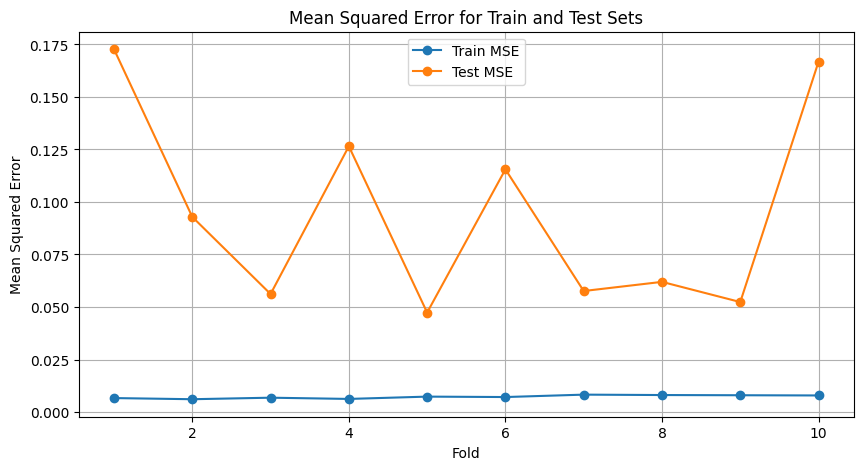

In [87]:
# Plotting the MSE for train and test sets
plt.figure(figsize=(10, 5))

# Plotting MSE for train set
plt.plot(range(1, len(mse_train_rf_list) + 1), mse_train_rf_list, marker='o', label='Train MSE')

# Plotting MSE for test set
plt.plot(range(1, len(mse_test_rf_list) + 1), mse_test_rf_list, marker='o', label='Test MSE')

plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error for Train and Test Sets')
plt.legend()
plt.grid(True)
plt.show()

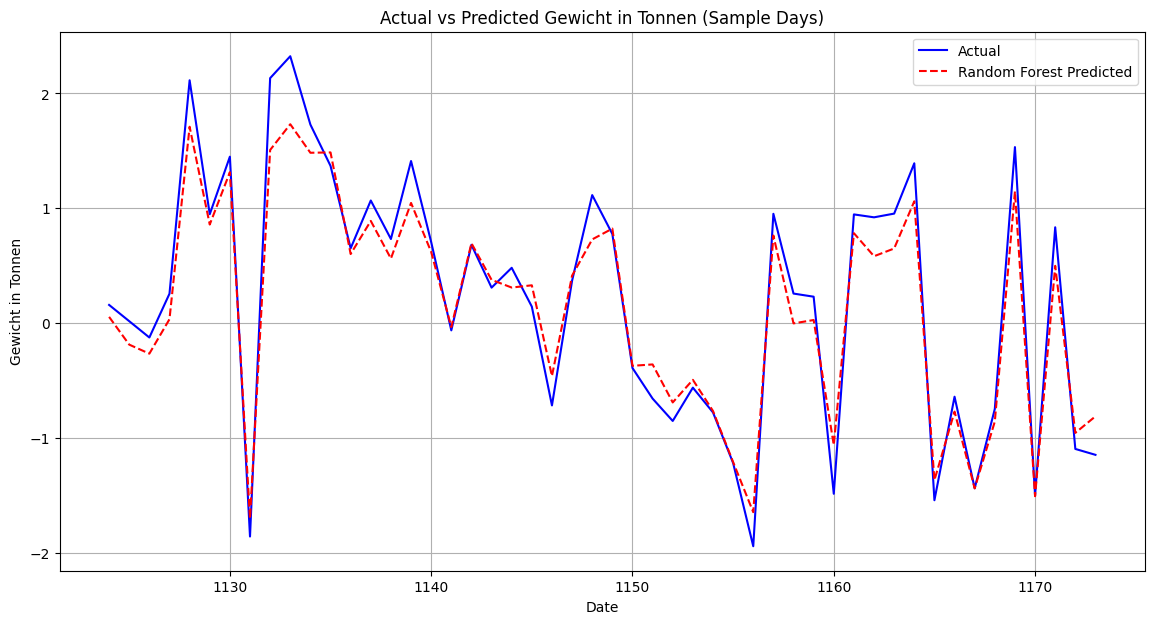

In [88]:
# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred_rf
})


# Select a subset of the data for illustration
subset_comparison_df = comparison_df.head(50) 

# Plotting the actual vs predicted "Gewicht in Tonnen" for the selected days
plt.figure(figsize=(14, 7))

# Plotting actual values
plt.plot(subset_comparison_df.index, subset_comparison_df['Actual'], label='Actual', color='blue')

# Plotting predicted values
plt.plot(subset_comparison_df.index, subset_comparison_df['Predicted'], label='Random Forest Predicted', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Gewicht in Tonnen')
plt.title('Actual vs Predicted Gewicht in Tonnen (Sample Days)')
plt.legend()
plt.grid(True)
plt.show()

